# Importing Necessary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,Subset,random_split
from torchvision import datasets,models
from torchvision import transforms as T
import torchvision.transforms.functional as TF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time,random
from torchvision.transforms.functional import to_pil_image
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Downloading The Dataset

In [2]:
transform = T.Compose([T.Resize((224,224))])
train = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)

# Set a seed for reproducibility
random.seed(42)
# Number of labeled and unlabeled samples
num_labeled = 8000
num_unlabeled = len(train) - num_labeled
# Randomly sample indices for the labeled dataset
labeled_indices = random.sample(range(len(train)), num_labeled)
# Collect indices for the unlabeled dataset
unlabeled_indices = [i for i in range(len(train)) if i not in labeled_indices]
# Create subsets for labeled and unlabeled datasets
train_dataset = Subset(train, labeled_indices)
unlabeled = Subset(train, unlabeled_indices)

100%|██████████| 170498071/170498071 [00:03<00:00, 48882170.88it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


# Transforming The Dataset and Dividing into Batches

In [11]:
class MyDataset(Dataset):
    def __init__(self, dataset, mutation=False):
        self.dataset = dataset
        self.mutation = mutation

    def __len__(self):
        return len(self.dataset)

    def tensorify(self, img):
        res = T.ToTensor()(img)
        res = T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(res)
        return res

    # Here, s is the strength of color distortion.
    def get_color_distortion(self,s=1.0):
        color_jitter = T.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
        rnd_color_jitter = T.RandomApply([color_jitter], p=0.8)
        # p is the probability of grayscale, here 0.2
        rnd_gray = T.RandomGrayscale(p=0.2)
        color_distort = T.Compose([rnd_color_jitter, rnd_gray])
        return color_distort

    def mutate_image(self, img):
        res = T.RandomResizedCrop(224)(img)
        res = self.get_color_distortion(1)(res)
        return res

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.mutation:
            image1 = self.mutate_image(img)
            image1 = self.tensorify(image1)
            image2 = self.mutate_image(img)
            image2 = self.tensorify(image2)
            sample = {'image1': image1, 'image2': image2,'label': label}

        else:
            img = T.Resize((224, 224))(img)
            img = self.tensorify(img)
            sample = {'image': img,'label': label}

        return sample


# Create an instance of MyDataset for the unlabeled dataset
transformed_unlabeled_dataset = MyDataset(unlabeled,True)
transformed_train_dataset = MyDataset(train_dataset)
transformed_test_dataset = MyDataset(test_dataset)

finetuning_dataset = DataLoader(transformed_train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_dataset = DataLoader(transformed_test_dataset, batch_size=256, shuffle=True, num_workers=2)

# Creating Imagenet Pretrained Resnet-18 as Feature Extractor

In [5]:
resnet_dict = {"resnet18": models.resnet18(pretrained=True, num_classes=1000),
                            "resnet50": models.resnet50(pretrained=True, num_classes=1000)}
feature_extractor = resnet_dict["resnet18"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 37.3MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 28.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# TSNE Visualization Of 1000d vectors(after passing through feature extractor) in 2d

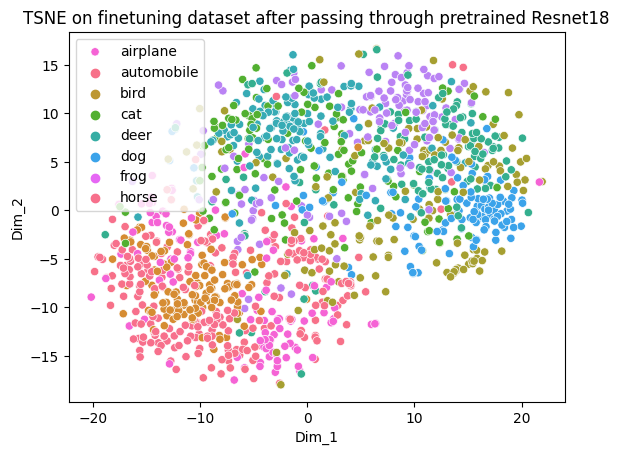

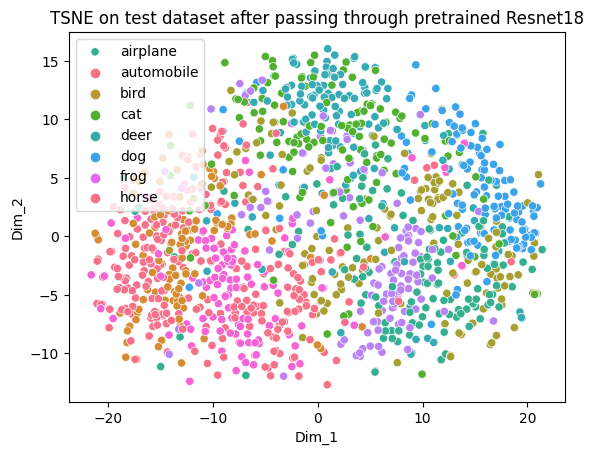

CPU times: user 42.1 s, sys: 3.12 s, total: 45.2 s
Wall time: 41.5 s


In [6]:
%%time
# Define class names for CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
tsne = TSNE(n_components=2, perplexity=50,random_state=42)     

data = []
labels = []
c = 0
# Loop through batches
for batch in finetuning_dataset:
    if c!=5:
      inputs = batch['image'].to(device)
      outputs = feature_extractor(inputs)  # Adjusting input shape for model inference
      batch_data, batch_labels = outputs.detach().cpu().numpy(), batch['label'].detach().cpu().numpy()
      data.extend(batch_data)
      labels.extend(batch_labels)
      c = c+1
data = np.array(data)

y_tsne = tsne.fit_transform(data)
fname = f"tsne_finetuning_dataset_pretrained_resnet18.png"  # Adjusted file name
tsne_data = np.vstack((y_tsne.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.scatterplot(x="Dim_1", y="Dim_2", hue="label", data=tsne_df,palette="husl")
# Manually set the legend labels
plt.legend(labels=class_names)
plt.title('TSNE on finetuning dataset after passing through pretrained Resnet18')
plt.savefig(fname)
plt.show()


data = []
labels = []
c = 0
# Loop through batches
for batch in test_dataset:
    if c!=5:
      inputs = batch['image'].to(device)
      outputs = feature_extractor(inputs)  # Adjusting input shape for model inference
      batch_data, batch_labels = outputs.detach().cpu().numpy(), batch['label'].detach().cpu().numpy()
      data.extend(batch_data)
      labels.extend(batch_labels)
      c = c+1
data = np.array(data)

y_tsne = tsne.fit_transform(data)
fname = f"tsne_test_dataset_pretrained_resnet18.png"  # Adjusted file name
tsne_data = np.vstack((y_tsne.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.scatterplot(x="Dim_1", y="Dim_2", hue="label", data=tsne_df,palette="husl")
# Manually set the legend labels
plt.legend(labels=class_names)
plt.title('TSNE on test dataset after passing through pretrained Resnet18')
plt.savefig(fname)
plt.show()

# Creating A Finetuning Head

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(1000, 512)  
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)  
        self.relu = nn.ReLU()   
        
    def forward(self, x):
        # Forward pass
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Create an instance of the neural network
model = NeuralNetwork().to(device)

# Print the model architecture
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=1000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


# Finetuning

Epoch 1/20: 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Epoch [1/20], Training Loss: 1.0601, Training Accuracy: 64.08%, Validation Loss: 0.8318, Validation Accuracy: 71.93%


Epoch 2/20: 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


Epoch [2/20], Training Loss: 0.6478, Training Accuracy: 77.25%, Validation Loss: 0.7451, Validation Accuracy: 75.00%


Epoch 3/20: 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


Epoch [3/20], Training Loss: 0.5388, Training Accuracy: 80.69%, Validation Loss: 0.7571, Validation Accuracy: 75.53%


Epoch 4/20: 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


Epoch [4/20], Training Loss: 0.4902, Training Accuracy: 82.95%, Validation Loss: 0.7598, Validation Accuracy: 76.07%


Epoch 5/20: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


Epoch [5/20], Training Loss: 0.4045, Training Accuracy: 86.12%, Validation Loss: 0.7468, Validation Accuracy: 75.20%
Early stopping triggered.


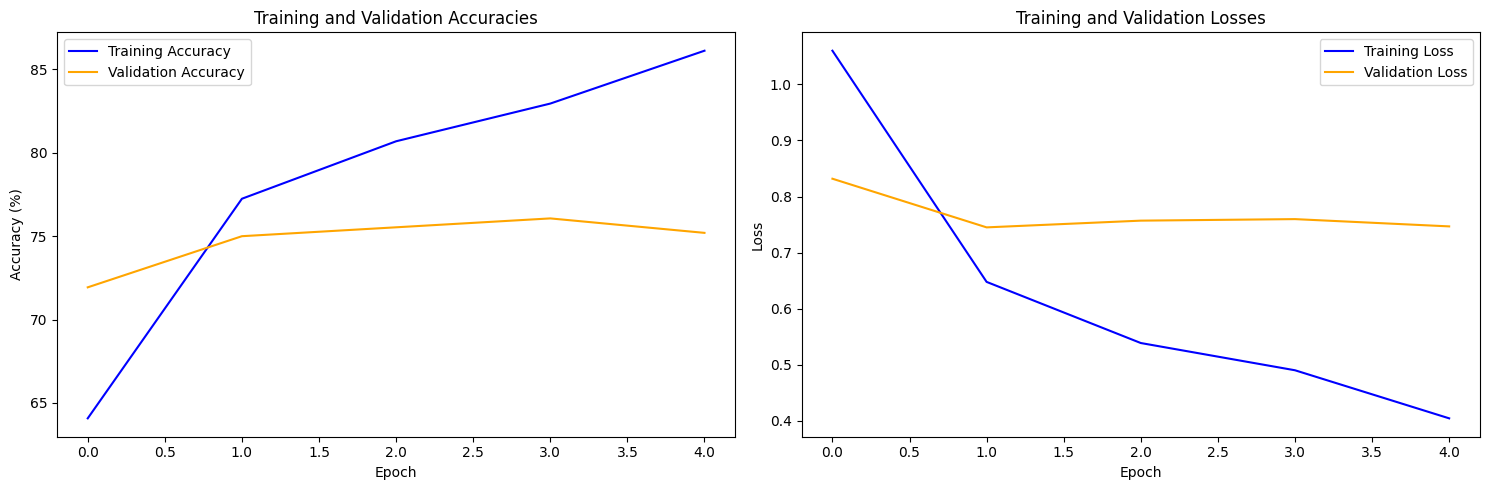

CPU times: user 55.6 s, sys: 7.4 s, total: 1min 3s
Wall time: 1min 13s


In [8]:
%%time

torch.manual_seed(42) 
# Split dataset into train and validation sets
# Define the sizes for train and validation datasets
train_size = 6500
val_size = 1500

# Split the dataset
train_dataset, val_dataset = random_split(transformed_train_dataset, [train_size, val_size])
train_dataset = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_dataset = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Number of epochs
num_epochs = 20

# Lists to store loss and accuracy values for plotting later
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Initialize early stopping parameters
best_val_loss = float('inf')
patience = 3
counter = 0

# Train loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    # wrap dataset with tqdm to get a progress bar
    t_dataset = tqdm(train_dataset, total=len(train_dataset), desc=f"Epoch {epoch+1}/{num_epochs}")
    # run a for loop for each batch
    for (_, batch) in enumerate(t_dataset):
        images = batch['image'].to(device)  
        labels = batch['label'].to(device)  
        optimizer.zero_grad()
        # Pass each datapoint through simclr.backbone
        features = feature_extractor(images)
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    v_dataset = tqdm(val_dataset, total=len(val_dataset), desc=f"Epoch {epoch+1}/{num_epochs}")
    with torch.no_grad():
        for (_, batch) in enumerate(v_dataset):
            images = batch['image'].to(device)    
            labels = batch['label'].to(device)  
            # Pass each datapoint through simclr.backbone
            features = feature_extractor(images)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.2f}%, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%')

    # Early stopping
    if best_val_loss-epoch_val_loss >.01:
        best_val_loss = epoch_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Save the trained model
torch.save(model.state_dict(), '/kaggle/working/supervised_model.pth')

# Visualization Of Metrics
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation accuracies
axs[0].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[0].plot(val_accuracies, label='Validation Accuracy', color='orange')
axs[0].set_title('Training and Validation Accuracies')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend()

# Plot training and validation losses
axs[1].plot(train_losses, label='Training Loss', color='blue')
axs[1].plot(val_losses, label='Validation Loss', color='orange')
axs[1].set_title('Training and Validation Losses')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()


# Adjust layout
plt.tight_layout()

# Save the plot as an image
plt.savefig('/kaggle/working/training_validation_metrics_supervised.png')

# Show plot
plt.show()


# Testing

100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


Accuracy: 0.7558
F1 Score: 0.7543497524682713


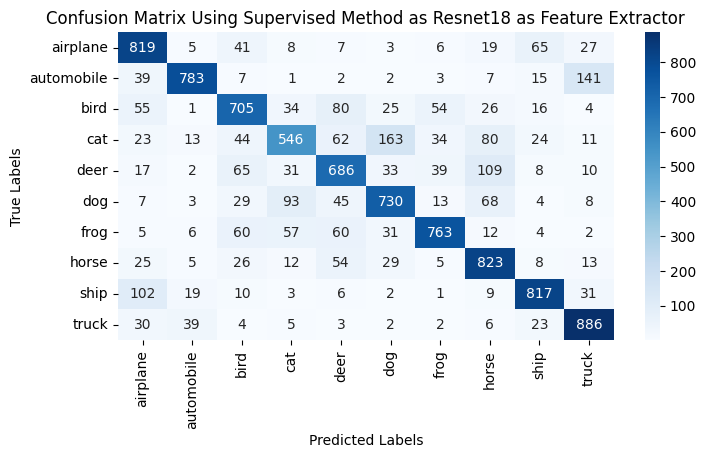

In [9]:
test_dataset = DataLoader(transformed_test_dataset, batch_size=256, shuffle=True, num_workers=2)
# Define lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

model = NeuralNetwork()
model_path = '/kaggle/working/supervised_model.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)
# Set the model to evaluation mode
model.eval()

t_dataset = tqdm(test_dataset, total=len(test_dataset))
# Iterate through the test dataset and make predictions
with torch.no_grad():
  for (_, batch) in enumerate(t_dataset):
      images = batch['image'].to(device)  
      labels = batch['label'].to(device)
      features = feature_extractor(images)
      outputs = model(features)
      _, predicted = torch.max(outputs, 1)
      true_labels.extend(labels.detach().cpu().numpy())
      predicted_labels.extend(predicted.detach().cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("F1 Score:", f1)

# Plot the confusion matrix
plt.figure(figsize=(8, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Using Supervised Method as Resnet18 as Feature Extractor')
plt.savefig('/kaggle/working/supervised_ Resnet18 as Feature Extractor_confusion_matrix.png')
plt.show()